In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from datetime import datetime
import warnings
import gc
from collections import Counter
from imblearn.over_sampling import SMOTE
warnings.filterwarnings('ignore')

In [7]:
# Configuration des graphiques
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 10

In [8]:
try:
    # Charger le fichier complet en DataFrame
    df_full = pd.read_csv('../data/bank_customer_churn.csv')
    print(f"✅ Fichier bank_customer_churn.csv chargé avec succès!")
    print(f"   📊 Dimensions totales: {df_full.shape[0]:,} lignes × {df_full.shape[1]} colonnes")
    print(f"   💾 Taille mémoire: {df_full.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
except FileNotFoundError:
    print("❌ Erreur: Le fichier 'bank_customer_churn.csv' n'a pas été trouvé!")
    print("   Veuillez vérifier que le fichier existe dans le répertoire de travail.")
    raise

✅ Fichier bank_customer_churn.csv chargé avec succès!
   📊 Dimensions totales: 115,640 lignes × 25 colonnes
   💾 Taille mémoire: 112.04 MB


In [9]:
# Définir le nombre de lignes à extraire
n_rows = 30000

In [10]:
if len(df_full) >= n_rows:
    df_300k = df_full.head(n_rows).copy()
    print(f"\n✅ Extraction réussie de {n_rows:,} lignes ({(n_rows/len(df_full)*100):.1f}% du total)")
else:
    df_300k = df_full.copy()
    print(f"\n⚠️  Le fichier contient seulement {len(df_full):,} lignes")
    print(f"   Toutes les lignes seront utilisées")
    n_rows = len(df_full)

print(f"📊 Dimensions extraites: {df_300k.shape[0]:,} lignes × {df_300k.shape[1]} colonnes")


✅ Extraction réussie de 30,000 lignes (25.9% du total)
📊 Dimensions extraites: 30,000 lignes × 25 colonnes


In [11]:
# Vérifier que la distribution de la variable cible est maintenue
if 'Churn Flag' in df_300k.columns:
    original_churn_rate = df_full['Churn Flag'].mean() * 100
    extracted_churn_rate = df_300k['Churn Flag'].mean() * 100
    print(f"\n   Vérification de la distribution de churn:")
    print(f"   • Taux de churn original: {original_churn_rate:.3f}%")
    print(f"   • Taux de churn extrait: {extracted_churn_rate:.3f}%")
    if abs(original_churn_rate - extracted_churn_rate) < 0.1:
        print(f"✅ Distribution similaire maintenue")
    else:
        print(f"⚠️  Différence de distribution: {abs(original_churn_rate - extracted_churn_rate):.3f}%")


   Vérification de la distribution de churn:
   • Taux de churn original: 12.188%
   • Taux de churn extrait: 12.353%
⚠️  Différence de distribution: 0.166%


In [12]:
# Libérer la mémoire du DataFrame complet
del df_full
import gc
gc.collect()
print("🗑️  Mémoire libérée (DataFrame original supprimé)")

🗑️  Mémoire libérée (DataFrame original supprimé)


In [13]:
df_300k.to_csv('../data/churn.csv', index=False)
print(f"✅ Export réussi!")
print(f"📁 Fichier créé: churn.csv ({n_rows:,} lignes)")
print(f"💾 Taille du fichier: ~{df_300k.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

✅ Export réussi!
📁 Fichier créé: churn.csv (30,000 lignes)
💾 Taille du fichier: ~29.07 MB


In [14]:
df = pd.read_csv('../data/churn.csv')
print(f"✅ Fichier churn.csv chargé avec succès!")
print(f"📊 Dimensions: {df.shape[0]:,} lignes × {df.shape[1]} colonnes")
print(f"💾 Utilisation mémoire: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

✅ Fichier churn.csv chargé avec succès!
📊 Dimensions: 30,000 lignes × 25 colonnes
💾 Utilisation mémoire: 29.07 MB


In [15]:
# ============================================================================
# 1. DROP UNNECESSARY COLUMNS
# ============================================================================
# Remove columns that won't help with prediction
columns_to_drop = [
    'RowNumber',           # Just an index
    'CustomerId',          # Unique identifier (no predictive value)
    'Surname',             # Personal identifier (no predictive value)
    'First Name',          # Personal identifier (no predictive value)
    'Address',             # Unique for each customer
    'Contact Information', # Unique for each customer
    'Churn Reason',        # This is a result of churn, not a predictor
    'Churn Date'           # This is a result of churn, not a predictor
]

df_clean = df.drop(columns=columns_to_drop)
print(f"\nAfter dropping unnecessary columns: {df_clean.shape}")



After dropping unnecessary columns: (30000, 17)


In [16]:
# ============================================================================
# 2. DATE FEATURE ENGINEERING
# ============================================================================
# Convert Date of Birth to datetime
df_clean['Date of Birth'] = pd.to_datetime(df_clean['Date of Birth'], format='%Y-%m-%d', errors='coerce')

# Create age feature
reference_date = pd.Timestamp('2024-12-11')  # Current date
df_clean['Age'] = (reference_date - df_clean['Date of Birth']).dt.days / 365.25
df_clean['Age'] = df_clean['Age'].round(0).astype(int)

# Create age groups
df_clean['Age_Group'] = pd.cut(df_clean['Age'], 
                                bins=[0, 25, 35, 45, 55, 65, 100],
                                labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+'])

# Drop original date column
df_clean = df_clean.drop(columns=['Date of Birth'])

print(f"\nAge statistics:")
print(df_clean['Age'].describe())


Age statistics:
count    30000.0000
mean        47.3722
std         16.7211
min         18.0000
25%         33.0000
50%         47.0000
75%         62.0000
max         76.0000
Name: Age, dtype: float64


In [17]:
# ============================================================================
# 3. FEATURE ENGINEERING
# ============================================================================

# Income per dependent
df_clean['Income_Per_Dependent'] = df_clean['Income'] / (df_clean['Number of Dependents'] + 1)

# Balance per product
df_clean['Balance_Per_Product'] = df_clean['Balance'] / df_clean['NumOfProducts']

# Credit utilization (Outstanding Loans / Income)
df_clean['Credit_Utilization'] = df_clean['Outstanding Loans'] / df_clean['Income']

# Loan to Balance ratio
df_clean['Loan_To_Balance_Ratio'] = df_clean['Outstanding Loans'] / (df_clean['Balance'] + 1)

# Tenure groups
df_clean['Tenure_Group'] = pd.cut(df_clean['Customer Tenure'],
                                   bins=[0, 6, 12, 24, 30],
                                   labels=['0-6m', '6-12m', '1-2y', '2y+'])

# Credit score categories
df_clean['Credit_Category'] = pd.cut(df_clean['Credit Score'],
                                      bins=[0, 579, 669, 739, 799, 850],
                                      labels=['Poor', 'Fair', 'Good', 'Very Good', 'Excellent'])

# Products per tenure (engagement metric)
df_clean['Products_Per_Year'] = df_clean['NumOfProducts'] / (df_clean['Customer Tenure'] / 12 + 0.1)

# Complaints per year
df_clean['Complaints_Per_Year'] = df_clean['NumComplaints'] / (df_clean['Customer Tenure'] / 12 + 0.1)

# High value customer flag
df_clean['High_Value_Customer'] = ((df_clean['Balance'] > df_clean['Balance'].quantile(0.75)) & 
                                    (df_clean['NumOfProducts'] >= 3)).astype(int)

# At-risk flag (high complaints + low balance)
df_clean['At_Risk'] = ((df_clean['NumComplaints'] > df_clean['NumComplaints'].median()) & 
                        (df_clean['Balance'] < df_clean['Balance'].median())).astype(int)

print(f"\nAfter feature engineering: {df_clean.shape}")


After feature engineering: (30000, 28)


In [18]:
# ============================================================================
# 4. HANDLE MISSING VALUES (if any)
# ============================================================================
missing_before = df_clean.isnull().sum().sum()
print(f"\nMissing values before imputation: {missing_before}")

# Fill any missing numerical values with median
numerical_cols = df_clean.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)

# Fill any missing categorical values with mode
categorical_cols = df_clean.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

missing_after = df_clean.isnull().sum().sum()
print(f"Missing values after imputation: {missing_after}")


Missing values before imputation: 0
Missing values after imputation: 0


In [19]:
# ============================================================================
# 5. ENCODE CATEGORICAL VARIABLES
# ============================================================================

# Binary encoding for Gender
df_clean['Gender'] = df_clean['Gender'].map({'Male': 1, 'Female': 0})

# One-hot encoding for categorical variables with few categories
categorical_to_encode = ['Marital Status', 'Education Level', 'Customer Segment', 
                         'Preferred Communication Channel', 'Age_Group', 'Tenure_Group', 
                         'Credit_Category']

df_encoded = pd.get_dummies(df_clean, columns=categorical_to_encode, drop_first=True, dtype=int)

# Label encoding for high-cardinality categorical variable (Occupation)
if 'Occupation' in df_encoded.columns:
    le = LabelEncoder()
    df_encoded['Occupation_Encoded'] = le.fit_transform(df_encoded['Occupation'])
    df_encoded = df_encoded.drop(columns=['Occupation'])

print(f"\nAfter encoding: {df_encoded.shape}")
print(f"Number of features: {df_encoded.shape[1] - 1}")  # Excluding target


After encoding: (30000, 41)
Number of features: 40


In [20]:
# ============================================================================
# 6. HANDLE OUTLIERS (Optional - using IQR capping)
# ============================================================================
def cap_outliers(df, column, lower_percentile=0.01, upper_percentile=0.99):
    """Cap outliers at specified percentiles"""
    lower_cap = df[column].quantile(lower_percentile)
    upper_cap = df[column].quantile(upper_percentile)
    df[column] = df[column].clip(lower=lower_cap, upper=upper_cap)
    return df

# Cap outliers in key numerical features
outlier_cols = ['Income', 'Outstanding Loans', 'Balance', 'Income_Per_Dependent', 
                'Balance_Per_Product', 'Credit_Utilization']

for col in outlier_cols:
    if col in df_encoded.columns:
        df_encoded = cap_outliers(df_encoded, col)

print("\nOutliers capped for numerical features")


Outliers capped for numerical features


In [21]:
# ============================================================================
# 7. SEPARATE FEATURES AND TARGET
# ============================================================================
X = df_encoded.drop('Churn Flag', axis=1)
y = df_encoded['Churn Flag']

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nChurn distribution:\n{y.value_counts()}")
print(f"Churn rate: {y.mean()*100:.2f}%")


Features shape: (30000, 40)
Target shape: (30000,)

Churn distribution:
Churn Flag
0    26294
1     3706
Name: count, dtype: int64
Churn rate: 12.35%


In [22]:
# ============================================================================
# 8. TRAIN-TEST SPLIT (Stratified)
# ============================================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape}, Churn rate: {y_train.mean()*100:.2f}%")
print(f"Test set: {X_test.shape}, Churn rate: {y_test.mean()*100:.2f}%")


Train set: (24000, 40), Churn rate: 12.35%
Test set: (6000, 40), Churn rate: 12.35%


In [23]:
# ============================================================================
# 9. FEATURE SCALING
# ============================================================================
# Scale numerical features (fit on train, transform both)
scaler = StandardScaler()

# Get numerical columns (exclude binary encoded columns)
numerical_features = X_train.select_dtypes(include=[np.number]).columns.tolist()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

GESTION DU DÉSÉQUILIBRE DES CLASSES (SMOTE)

📊 Distribution AVANT SMOTE:
 Classe 0 (Non-churn) : 21,035
 Classe 1 (Churn)      : 2,965
 Ratio: 7.09:1



📊 Distribution APRÈS SMOTE:
 Classe 0 : 21,035
 Classe 1 : 21,035
 Ratio: 1:1 (équilibré)


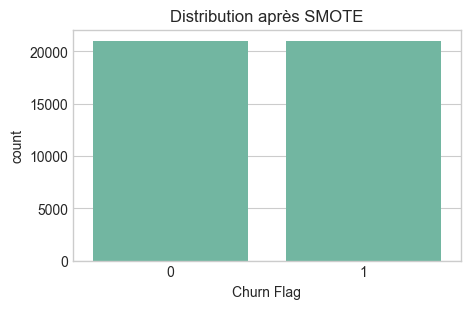

In [24]:
# ============================================================================
# 10. HANDLE CLASS IMBALANCE (Multiple Options)
# ============================================================================

print("="*80)
print("GESTION DU DÉSÉQUILIBRE DES CLASSES (SMOTE)")
print("="*80)

print("\n📊 Distribution AVANT SMOTE:")
print(f" Classe 0 (Non-churn) : {Counter(y_train)[0]:,}")
print(f" Classe 1 (Churn)      : {Counter(y_train)[1]:,}")
print(f" Ratio: {Counter(y_train)[0] / Counter(y_train)[1]:.2f}:1")

# SMOTE only if minority exists
if Counter(y_train)[1] > 1:
    smote = SMOTE(
        random_state=42,
        k_neighbors=min(5, Counter(y_train)[1] - 1)
    )
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

    print("\n📊 Distribution APRÈS SMOTE:")
    print(f" Classe 0 : {Counter(y_train_resampled)[0]:,}")
    print(f" Classe 1 : {Counter(y_train_resampled)[1]:,}")
    print(" Ratio: 1:1 (équilibré)")

    smote_applied = True
else:
    print("\n⚠️ Impossible d'appliquer SMOTE (classe minoritaire absente)")
    X_train_resampled, y_train_resampled = X_train_scaled, y_train
    smote_applied = False

# --- Optional visualization ---
plt.figure(figsize=(5,3))
sns.countplot(x=y_train_resampled)
plt.title("Distribution après SMOTE")
plt.show()


In [25]:
# ============================================================================
# 11. SAVE PROCESSED DATA
# ============================================================================
print("="*80)
print("SAUVEGARDE DES PROCESSEURS")
print("="*80)

import os, pickle
os.makedirs("processors", exist_ok=True)

# 1 — Save scaler
with open("processors/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
print("✓ Scaler sauvegardé")

# 2 — Save label encoders (occupation only)
with open("processors/label_encoders.pkl", "wb") as f:
    pickle.dump({"Occupation": le}, f)
print("✓ Label encoders sauvegardés")

# 3 — Save feature names
feature_names = {
    "numerical_features": numerical_features,
    "all_features": X.columns.tolist()
}
with open("processors/feature_names.pkl", "wb") as f:
    pickle.dump(feature_names, f)
print("✓ Noms des features sauvegardés")

# 4 — Save SMOTE config
with open("processors/smote_config.pkl", "wb") as f:
    pickle.dump({"applied": smote_applied, "strategy": "SMOTE"}, f)
print("✓ Configuration SMOTE sauvegardée")

# 5 — Save final datasets
datasets = {
    "X_train": X_train_resampled,
    "y_train": y_train_resampled,
    "X_test": X_test_scaled,
    "y_test": y_test
}
with open("processors/preprocessed_data.pkl", "wb") as f:
    pickle.dump(datasets, f)

print("\n✅ Tous les processeurs et données preprocessées ont été sauvegardés.")


SAUVEGARDE DES PROCESSEURS
✓ Scaler sauvegardé
✓ Label encoders sauvegardés
✓ Noms des features sauvegardés
✓ Configuration SMOTE sauvegardée

✅ Tous les processeurs et données preprocessées ont été sauvegardés.


In [26]:
df_encoded.to_csv("../data/preprocessed_data.csv", index=False)
print("✓ Fichier CSV sauvegardé sous: preprocessed_data.csv")


✓ Fichier CSV sauvegardé sous: preprocessed_data.csv
